In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For neural networks
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# For ACO
from scipy.optimize import differential_evolution


In [2]:
np.random.seed(42)


In [3]:
# Number of samples and features
n_samples = 10000
n_features = 5  # Reduced for computational efficiency


In [4]:
# Generate random input features between 0 and 10
X = np.random.uniform(0, 10, size=(n_samples, n_features))


In [5]:
# Random coefficients for the synthetic process
coefficients = np.random.uniform(-5, 5, size=n_features)


In [6]:
# Nonlinear function of inputs
y = (
    np.sin(np.dot(X, coefficients)) + 
    np.sum(np.square(X), axis=1) + 
    np.prod(np.cos(X), axis=1) + 
    np.random.normal(0, 1, n_samples)
)


In [7]:
# Feature names
columns = [f'x{i+1}' for i in range(n_features)]

# Combine features and target into a DataFrame
data = pd.DataFrame(X, columns=columns)
data['y'] = y


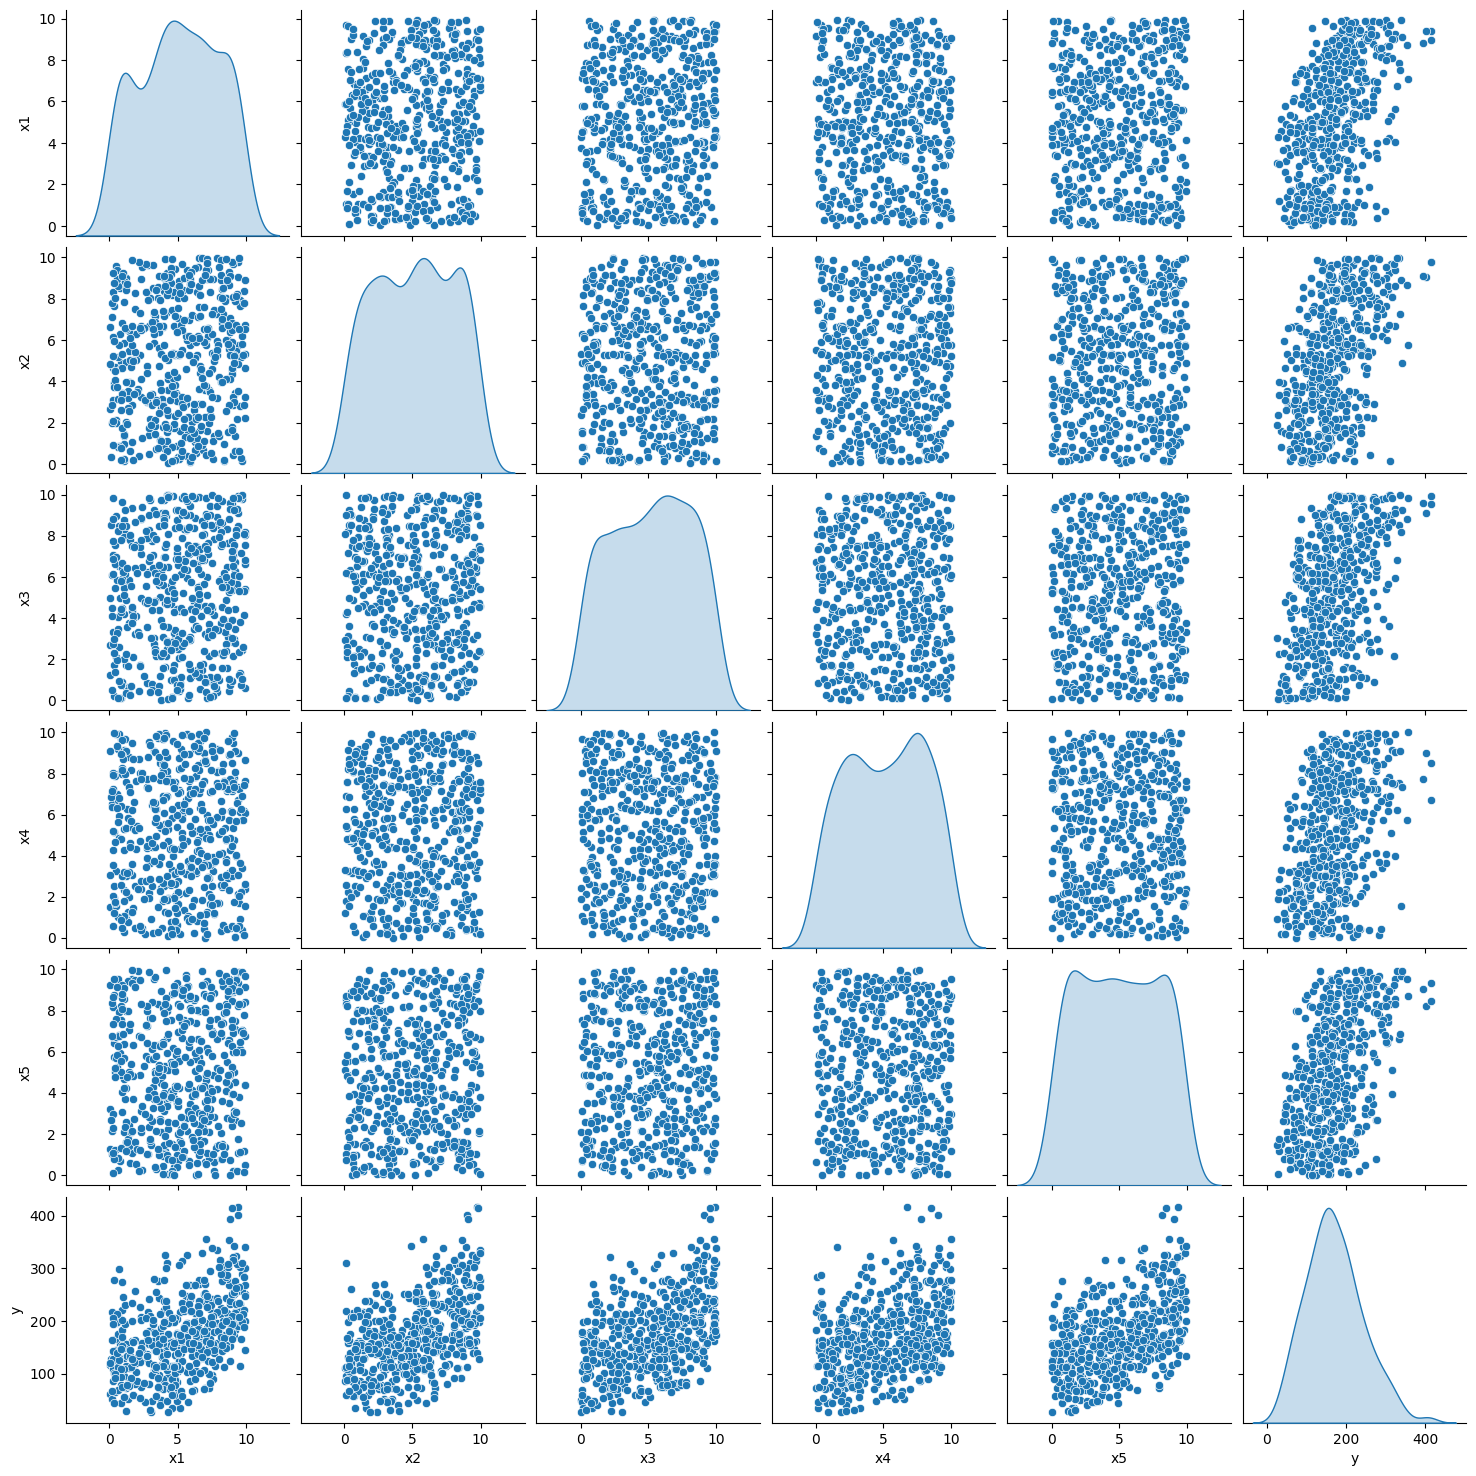

In [8]:
# Pairplot to visualize relationships
sns.pairplot(data.sample(500), diag_kind='kde')
plt.show()


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data into features and target
X = data.drop('y', axis=1).values
y = data['y'].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [10]:
# Build the neural network
model = Sequential([
    Dense(64, activation='relu', input_shape=(n_features,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [11]:
# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    verbose=1
)


Epoch 1/50

100/100 [==============================] - 1s 2ms/step - loss: 17788.4219 - val_loss: 438.2643
Epoch 2/50
100/100 [==============================] - 0s 1ms/step - loss: 185.1350 - val_loss: 122.2339
Epoch 3/50
100/100 [==============================] - 0s 1ms/step - loss: 106.0122 - val_loss: 85.4129
Epoch 4/50
100/100 [==============================] - 0s 1ms/step - loss: 79.4023 - val_loss: 67.6224
Epoch 5/50
100/100 [==============================] - 0s 1ms/step - loss: 63.8410 - val_loss: 55.0660
Epoch 6/50
100/100 [==============================] - 0s 1ms/step - loss: 51.4569 - val_loss: 45.2082
Epoch 7/50
100/100 [==============================] - 0s 1ms/step - loss: 41.1775 - val_loss: 35.8693
Epoch 8/50
100/100 [==============================] - 0s 1ms/step - loss: 32.7189 - val_loss: 29.0830
Epoch 9/50
100/100 [==============================] - 0s 1ms/step - loss: 26.1860 - val_loss: 23.4672
Epoch 10/50
100/100 [==============================] - 0s 1ms/step - loss:

In [12]:
# Evaluate on test data
test_loss = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Test MSE: {test_loss:.4f}')


Test MSE: 3.9944


In [13]:
# Define the objective function for optimization
def objective_function(x):
    # Reshape and scale the input
    x = np.array(x).reshape(1, -1)
    x_scaled = scaler.transform(x)
    # Predict using the neural network
    y_pred = model.predict(x_scaled)
    return y_pred[0][0]


In [14]:
# Define bounds for each variable
bounds = [(0, 10) for _ in range(n_features)]


In [18]:
# Perform optimization using differential evolution
result = differential_evolution(
    objective_function,
    bounds,
    strategy='best1bin',
    maxiter=100,
    popsize=15,
    tol=1e-6,
    mutation=(0.5, 1),
    recombination=0.7,
    seed=42
)

# Optimal input variables
optimal_x = result.x
optimal_y = result.fun

print(f'Optimal input variables: {optimal_x}')
print(f'Optimal output y: {optimal_y}')


1/1 [==============================] - 0s 17ms/step


KeyboardInterrupt: 

In [16]:
# Generate random samples
num_samples = 1000
random_X = np.random.uniform(0, 10, size=(num_samples, n_features))
random_X_scaled = scaler.transform(random_X)
random_y_pred = model.predict(random_X_scaled)

# Find the minimum y from random samples
min_index = np.argmin(random_y_pred)
random_optimal_x = random_X[min_index]
random_optimal_y = random_y_pred[min_index]

print(f'Random search optimal y: {random_optimal_y[0]}')


32/32 [==============================] - 0s 904us/step
Random search optimal y: 16.678680419921875


NameError: name 'optimal_y' is not defined

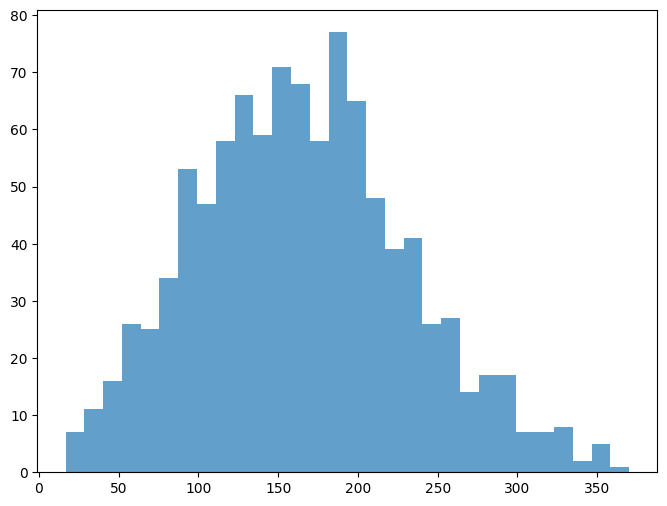

In [17]:
# Plot the distribution of predictions from random samples
plt.figure(figsize=(8, 6))
plt.hist(random_y_pred, bins=30, alpha=0.7)
plt.axvline(optimal_y, color='r', linestyle='dashed', linewidth=2, label='Optimized y')
plt.title('Distribution of Predicted y from Random Samples')
plt.xlabel('Predicted y')
plt.ylabel('Frequency')
plt.legend()
plt.show()
